In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['TRKXINPUTDIR']="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts"
os.environ['TRKXOUTPUTDIR']= "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/out0"

In [3]:
# import warnings
# warnings.filterwarnings("ignore")
# from utils_robust import *
import sys
import torch
import pytorch_lightning as pl
import yaml
import importlib
import trackml
import trackml.dataset
import numpy as np
from torch_cluster import radius_graph
from utils_torch import build_edges
sys.path.append('..')
sys.path.append('/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/')
from embedding.layerless_embedding import *
from embedding.embedding_base import *
from src.filter import filter_base
from src.filter.vanilla_filter import *
# from src.Embedding.utils import get_best_run, build_edges, res, graph_intersection
# from LightningModules.Filter.utils import stringlist_to_classes
# from src.filter.vanilla_filter import VanillaFilter, FilterInferenceCallback
# from src.Processing.feature_construction import FeatureStore
# from pytorch_lightning.loggers import WandbLogger
sys.path.append('/global/u2/c/caditi97/exatrkx-ctd2020')
import matplotlib.pyplot as plt
%matplotlib inline
# from utils_robust import *

In [4]:
noise_keeps = ["0", "0.2", "0.4", "0.6", "0.8", "1"]

# Noise 

-----
Data(cell_data=[103305, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[103305], layerless_true_edges=[2, 123429], layers=[103305], pid=[103305], x=[103305, 3])
-----
Data(cell_data=[106831, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[106831], layerless_true_edges=[2, 389588], layers=[106831], pid=[106831], x=[106831, 3])
-----
Data(cell_data=[110358, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[110358], layerless_true_edges=[2, 1146681], layers=[110358], pid=[110358], x=[110358, 3])
-----
Data(cell_data=[113885, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[113885], layerless_true_edges=[2, 2394184], layers=[113885], pid=[113885], x=[113885, 3])
-----
Data(cell_data=[117412, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[117412], layerles

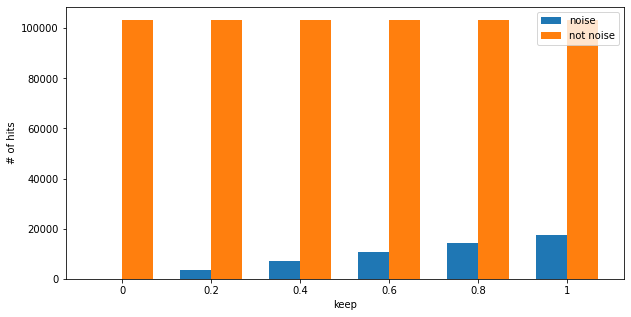

In [5]:
noise = []
not_noise = []
for i in noise_keeps:
    dir_path = "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020"
    data_path = f"/out{i}/feature_store/1000"
    #data = torch.load(f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/feature_store_endcaps/n{i}/1000")
    data = torch.load(dir_path + data_path)
    arr = data['pid']
    n_count = np.count_nonzero(arr==0)
    not_n = np.count_nonzero(arr)
    noise.append(n_count)
    not_noise.append(not_n)
    print("-----")
    print(data)
    
x = np.arange(len(noise_keeps))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, noise, width, label='noise')
rects2 = ax.bar(x + width/2, not_noise, width, label='not noise')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of hits')
ax.set_xlabel('keep')
ax.set_xticks(x)
labels = noise_keeps
ax.set_xticklabels(labels)
ax.legend()

# Embedding

In [6]:
# load model
emb_ckpt_path = '/global/cfs/cdirs/m3443/data/lightning_models/embedding/checkpoints/epoch=10.ckpt'
emb_ckpt = torch.load(emb_ckpt_path)

In [7]:
emb_ckpt['hyper_parameters']['train_split'] = [8,1,1]
emb_ckpt['hyper_parameters']['clustering'] = 'build_edges'
emb_ckpt['hyper_parameters']

"adjacent":       False
"clustering":     build_edges
"emb_dim":        8
"emb_hidden":     512
"endcaps":        True
"factor":         0.3
"in_channels":    12
"input_dir":      /global/cscratch1/sd/danieltm/ExaTrkX/trackml/feature_store_endcaps
"knn":            20
"layerless":      True
"layerwise":      False
"lr":             0.002
"margin":         1
"max_epochs":     100
"nb_layer":       6
"noise":          False
"output_dir":     global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/embedding_processed/0_pt_cut_endcaps
"overwrite":      True
"patience":       5
"project":        EmbeddingStudy
"pt_min":         0
"r_train":        1
"r_val":          0.5
"randomisation":  2
"regime":         ['rp', 'hnm', 'ci']
"train_split":    [8, 1, 1]
"wandb_save_dir": /global/cscratch1/sd/danieltm/ExaTrkX/wandb_data
"warmup":         500
"weight":         4

In [8]:
emb_model = LayerlessEmbedding(emb_ckpt['hyper_parameters'])

In [9]:
best_emb = emb_model.load_from_checkpoint(emb_ckpt_path, hparams=emb_ckpt['hyper_parameters'])

In [10]:
best_emb.eval()

LayerlessEmbedding(
  (layers): ModuleList(
    (0): Linear(in_features=12, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
  )
  (emb_layer): Linear(in_features=512, out_features=8, bias=True)
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (act): Tanh()
)

In [11]:
def emb_purity(best_emb,batch):
#     dev = 'cuda' if torch.cuda.is_available() else 'cpu'
#     hparams = ckpt['hyper_parameters']
    
    if 'ci' in best_emb.hparams["regime"]:
            spatial = best_emb(torch.cat([batch.cell_data, batch.x], axis=-1))
    else:
            spatial = best_emb(batch.x)
    
    # truth information
    e_bidir = torch.cat([batch.layerless_true_edges,
                        torch.stack([batch.layerless_true_edges[1],
                                    batch.layerless_true_edges[0]], axis=1).T], axis=-1)
    if(torch.cuda.is_available()):
        spatial = spatial.cuda()
        
    # clustering
    e_spatial = best_emb.clustering(spatial, best_emb.hparams["r_val"], best_emb.hparams["knn"])
    
    # label edges as true and false
    e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)
    
    cluster_true = 2*len(batch.layerless_true_edges[0])
    cluster_true_positive = y_cluster.sum()
    cluster_positive = len(e_spatial[0])
    
    # add all truth edges "weight" times, which is 4,
    # to balance the number of truth and fake edges in one batch
    
    if(torch.cuda.is_available()):
        e_spatial = e_spatial.cuda()
        e_bidir = e_bidir.cuda()
        
    
    e_spatial = torch.cat([e_spatial,
        e_bidir.transpose(0,1).repeat(1,best_emb.hparams["weight"]).view(-1, 2).transpose(0,1)], axis=-1)
    y_cluster = np.concatenate([y_cluster.astype(int), np.ones(e_bidir.shape[1]*best_emb.hparams["weight"])])

    
    # extract emedding features of seed hits and neighbor hits
    seed_hits = spatial.index_select(0, e_spatial[1])
    neighbors = spatial.index_select(0, e_spatial[0])

    
    # calculate purity as true hits inside embedding radius / total hits inside embedding radius
    
    return seed_hits, neighbors, e_spatial, y_cluster

In [12]:
n2_path = "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/out0.2/feature_store/1000"
data2 = torch.load(n2_path)
data2

Data(cell_data=[106831, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[106831], layerless_true_edges=[2, 389588], layers=[106831], pid=[106831], x=[106831, 3])

In [13]:
seed_hits, neighbors, e_spatial, y_cluster = emb_purity(best_emb, data2)

In [14]:
seed_hits[0]

tensor([-8.3380, -1.8881,  0.0560, -0.1523,  3.2889, -0.1843,  1.5527, -7.0874],
       device='cuda:0', grad_fn=<SelectBackward>)

In [15]:
neighbors[0]

tensor([-8.1426, -1.9134, -0.1716, -0.2233,  3.2029, -0.1741,  1.3431, -7.0850],
       device='cuda:0', grad_fn=<SelectBackward>)

In [16]:
len(e_spatial)

2

In [17]:
e_spatial[0, :]

tensor([     2,      2,      5,  ..., 100256, 100256, 100256], device='cuda:0')

In [18]:
e_spatial[1, :]

tensor([15264, 25232, 10051,  ..., 96630, 96630, 96630], device='cuda:0')

In [19]:
y_cluster

array([0., 0., 0., ..., 1., 1., 1.])

In [20]:
cluster_true_positive = y_cluster.sum()
cluster_positive = len(e_spatial[0])
pur = cluster_true_positive/cluster_positive
pur

0.9641246326647044

In [21]:
torch.tensor(cluster_true_positive/cluster_positive)

tensor(0.9641, dtype=torch.float64)

In [22]:
x = np.arange(len(noise_keeps))
purity = []
for i in noise_keeps:
    d_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/out{i}/feature_store/1000"
    data_in = torch.load(d_path)
    seed_hits, neighbors, e_spatial, y_cluster = emb_purity(best_emb, data_in)
    cluster_true_positive = y_cluster.sum()
    cluster_positive = len(e_spatial[0])
    pur = cluster_true_positive/cluster_positive
    purity.append(pur)

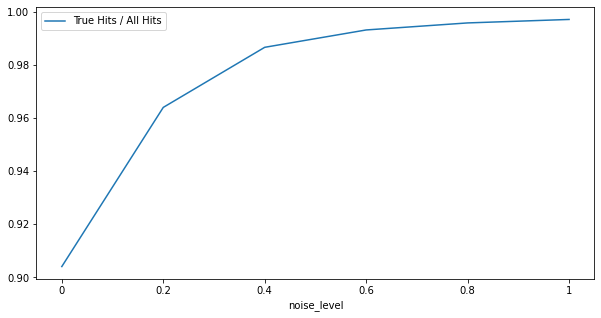

In [23]:
fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(x, purity, label = 'True Hits / All Hits')
ax1.set_xlabel('noise_level')
ax1.set_xticks(x)
labels = noise_keeps
ax1.set_xticklabels(labels)
ax1.legend()

In [24]:
# value = 0
# for nbr_ind in e_spatial[1,:]:
#     value += y_cluster[nbr_ind]
# value

# Filtering

In [25]:
# load model
filter_ckpt_path = '/global/cfs/cdirs/m3443/data/lightning_models/filtering/checkpoints/epoch=54.ckpt'
filter_ckpt = torch.load(filter_ckpt_path)
filter_model = VanillaFilter(filter_ckpt['hyper_parameters'])
best_filter = filter_model.load_from_checkpoint(filter_ckpt_path, hparams=filter_ckpt['hyper_parameters'])

In [26]:
best_filter.eval()

VanillaFilter(
  (input_layer): Linear(in_features=24, out_features=512, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (output_layer): Linear(in_features=512, out_features=1, bias=True)
  (layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (batchnorm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (act): Tanh()
)